In [2]:
import sys, os
from langchain_core.messages import HumanMessage
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..","..")))
print(os.path.abspath(os.path.join(os.getcwd(),"..","..")))
from src.agents.workflow import graph
from src.agents.analyst.analyst import AnalystAgent
from src.agents.writer.writer import WriterAgent
from src.agents.assigner.assigner import AssignerAgent
from src.agents.workflow import graph

input_state = {
    "messages": [
        HumanMessage(content="đạo hàm là gì và ví dụ phân tích từng bước (bài toán thực tế)"),
    ],
    "thread_id": "123",
    "agent_logs": [
        {
            "agent_name": "assginer",
            "task": None,
            "result": None,
            "start_time": None,
            "end_time": None,
            "duration": None,
        }
    ],
    "next_agent": None,
    "prev_agent": None,
    "task": "",
}
config = {"configurable": {"thread_id": "123"}}
async for event in graph.astream(
    input_state,
    config=config,
    stream_mode=["messages","updates"],
):
    data_type, payload = event
    print(event)


e:\Project\chatbot
('messages', (AIMessageChunk(content='anal', additional_kwargs={}, response_metadata={'safety_ratings': []}, id='run--e2cb233a-d4c9-4b01-a737-42dbef2f5a83', usage_metadata={'input_tokens': 122, 'output_tokens': 0, 'total_tokens': 122, 'input_token_details': {'cache_read': 0}}), {'thread_id': '123', 'langgraph_step': 1, 'langgraph_node': 'assigner', 'langgraph_triggers': ('branch:to:assigner',), 'langgraph_path': ('__pregel_pull', 'assigner'), 'langgraph_checkpoint_ns': 'assigner:c9d1e1f3-d1b8-8a9c-86d8-7d5e385ca28a|assigner:7fb0f76f-4c66-36e7-9fb8-958123314da3', 'checkpoint_ns': 'assigner:c9d1e1f3-d1b8-8a9c-86d8-7d5e385ca28a', 'ls_provider': 'google_genai', 'ls_model_name': 'gemini-2.0-flash', 'ls_model_type': 'chat', 'ls_temperature': 0.7}))
('messages', (AIMessageChunk(content='yst\n', additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--e2cb233a-d4c9-4b01-a737-42dbef2f5a83', usage_metad

e:\Project\chatbot
Error loading supported_apps.json: [Errno 2] No such file or directory: 'src/config/system/supported_apps.json'


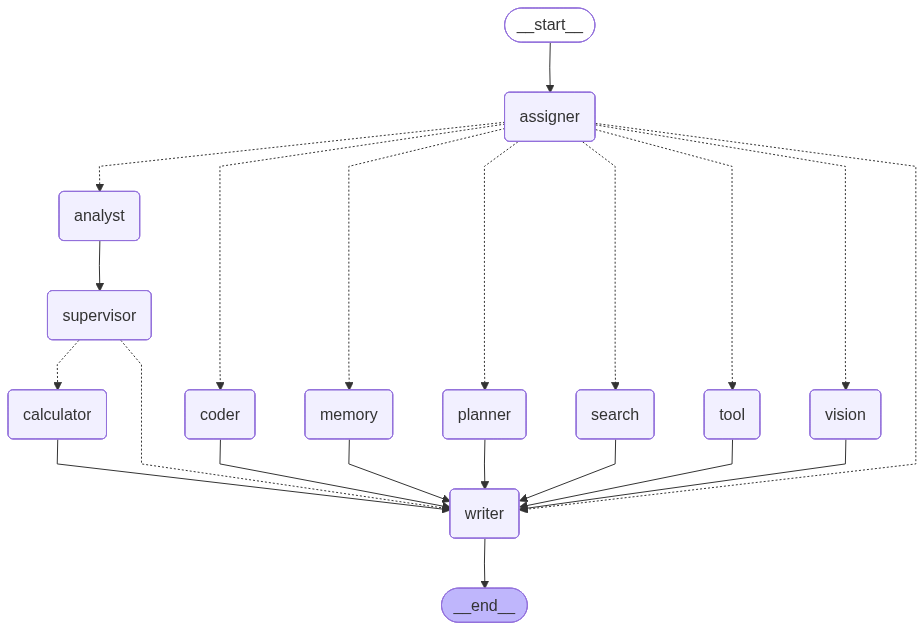

In [1]:
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image
import sys, os
from langchain_core.messages import HumanMessage

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "..")))
print(os.path.abspath(os.path.join(os.getcwd(), "..", "..")))
from src.agents.workflow import graph
from src.agents.analyst.analyst import AnalystAgent
from src.agents.writer.writer import WriterAgent
from src.agents.assigner.assigner import AssignerAgent
from src.agents.workflow import graph

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        ),
    )
)

